In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

# 读取数据
train = pd.read_csv('train.csv', on_bad_lines='skip')
test = pd.read_csv('test.csv', on_bad_lines='skip')

# 移除 id 列
id = test['id']
train.drop(columns=['id'], inplace=True)
test.drop(columns=['id'], inplace=True)

# 修改 CALC 列
test.loc[test['CALC']=='Always', 'CALC'] = 'Frequently'

# 标签编码目标变量
le = LabelEncoder()
train['NObeyesdad'] = le.fit_transform(train['NObeyesdad'])

# 分离特征和目标变量
X = train.drop(columns=['NObeyesdad'])
y = train['NObeyesdad']

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# 定义数值列
num_cols = [col for col in X.columns if X[col].dtype == 'float']

# 定义预处理步骤
preprocessor = ColumnTransformer(transformers=[
    ('tnf1', OneHotEncoder(sparse_output=False, drop='first', dtype='int'), ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC', 'MTRANS']),
    ('tnf2', OrdinalEncoder(dtype='int'), ['CAEC', 'CALC']),
    ('tnf3', StandardScaler(), num_cols)
], remainder='passthrough')

# 定义模型和参数网格
model = SVC(probability=True)
param_grid = {
    'svc__C': [1, 10, 100],
    'svc__gamma': [0.01, 0.1, 10],
    'svc__kernel':['linear']#, 'sigmoid','poly']#, 'rbf']
}

# 创建管道
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('svc', model)
])

# 创建 GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=2)

# 拟合 GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ......svc__C=1, svc__gamma=0.01, svc__kernel=linear; total time=   4.3s
[CV] END ......svc__C=1, svc__gamma=0.01, svc__kernel=linear; total time=   4.3s
[CV] END ......svc__C=1, svc__gamma=0.01, svc__kernel=linear; total time=   4.2s
[CV] END ......svc__C=1, svc__gamma=0.01, svc__kernel=linear; total time=   4.4s
[CV] END ......svc__C=1, svc__gamma=0.01, svc__kernel=linear; total time=   4.4s
[CV] END .......svc__C=1, svc__gamma=0.1, svc__kernel=linear; total time=   4.3s
[CV] END .......svc__C=1, svc__gamma=0.1, svc__kernel=linear; total time=   4.4s
[CV] END .......svc__C=1, svc__gamma=0.1, svc__kernel=linear; total time=   4.2s
[CV] END .......svc__C=1, svc__gamma=0.1, svc__kernel=linear; total time=   4.6s
[CV] END .......svc__C=1, svc__gamma=0.1, svc__kernel=linear; total time=   4.6s
[CV] END ........svc__C=1, svc__gamma=10, svc__kernel=linear; total time=   4.4s
[CV] END ........svc__C=1, svc__gamma=10, svc__ke

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('tnf1',
                                                                         OneHotEncoder(drop='first',
                                                                                       dtype='int',
                                                                                       sparse_output=False),
                                                                         ['Gender',
                                                                          'family_history_with_overweight',
                                                                          'FAVC',
                                                                          'SMOKE',
                                                                          'SCC',
                                                                          'MTRANS']),
                                                                        ('tnf2',
                                                                         OrdinalEncoder(dtype='int'),
                                                                         ['CAEC',
                                                                          'CALC']),
                                                                        ('tnf3',
                                                                         StandardScaler(),
                                                                         ['Age',
                                                                          'Height',
                                                                          'Weight',
                                                                          'FCVC',
                                                                          'NCP',
                                                                          'CH2O',
                                                                          'FAF',
                                                                          'TUE'])])),
                                       ('svc', SVC(probability=True))]),
             param_grid={'svc__C': [1, 10, 100], 'svc__gamma': [0.01, 0.1, 10],
                         'svc__kernel': ['linear']},
             scoring='accuracy', verbose=2)

In [25]:
print("最优参数:", grid_search.best_params_)
print("最优核函数:", grid_search.best_estimator_.named_steps['svc'].kernel)

最优参数: {'svc__C': 100, 'svc__gamma': 0.01, 'svc__kernel': 'linear'}
最优核函数: linear


In [26]:
# 验证集上的性能
y_pred = grid_search.predict(X_val)
y_prob = grid_search.predict_proba(X_val)  # 获取预测概率
accuracy = accuracy_score(y_val, y_pred)
print(f"验证集准确率: {accuracy:.2f}")

验证集准确率: 0.87


In [27]:
# 测试集上的预测
# 使用 best_estimator_ 来进行预测，因为 best_estimator_ 包含了完整的预处理和模型步骤
best_pipeline = grid_search.best_estimator_
X_test_transformed = best_pipeline.named_steps['preprocessor'].transform(test)
test_predictions = best_pipeline.predict(test)

In [28]:
# 将预测结果转换回原始标签
test_predictions = le.inverse_transform(test_predictions)

# 保存预测结果
submission = pd.DataFrame({'id': id, 'NObeyesdad': test_predictions})
submission.to_csv('submission_svm.csv', index=False)

验证集准确率: 0.87
验证集精确率: 0.87
验证集召回率: 0.87
验证集 F1 分数: 0.87
验证集 ROC AUC: 0.98


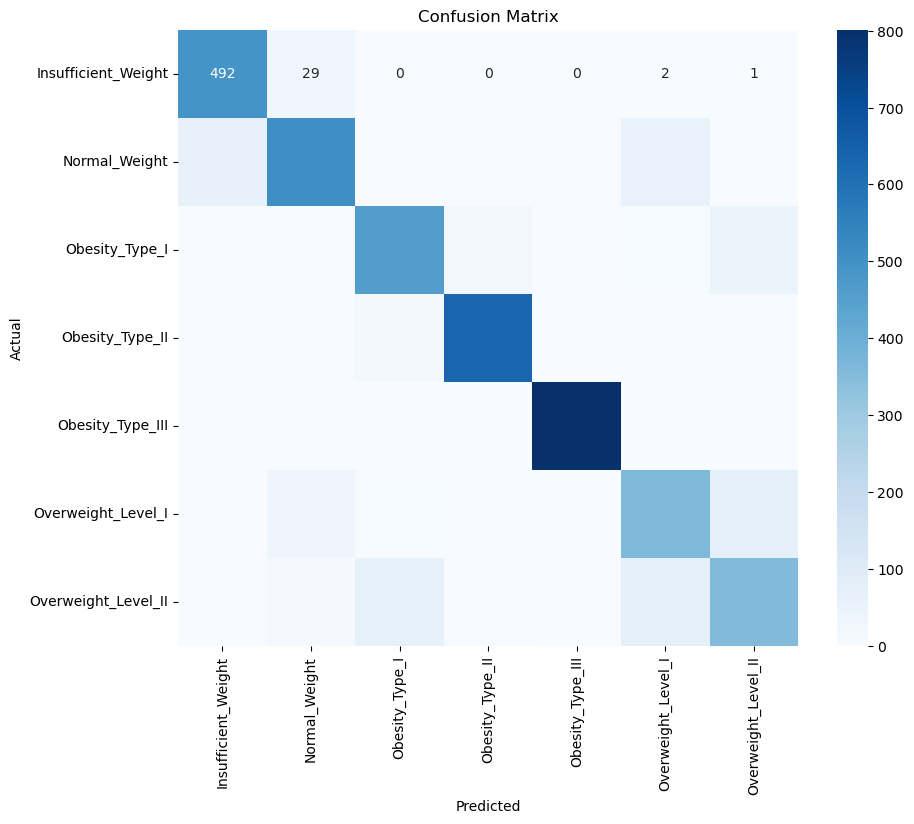

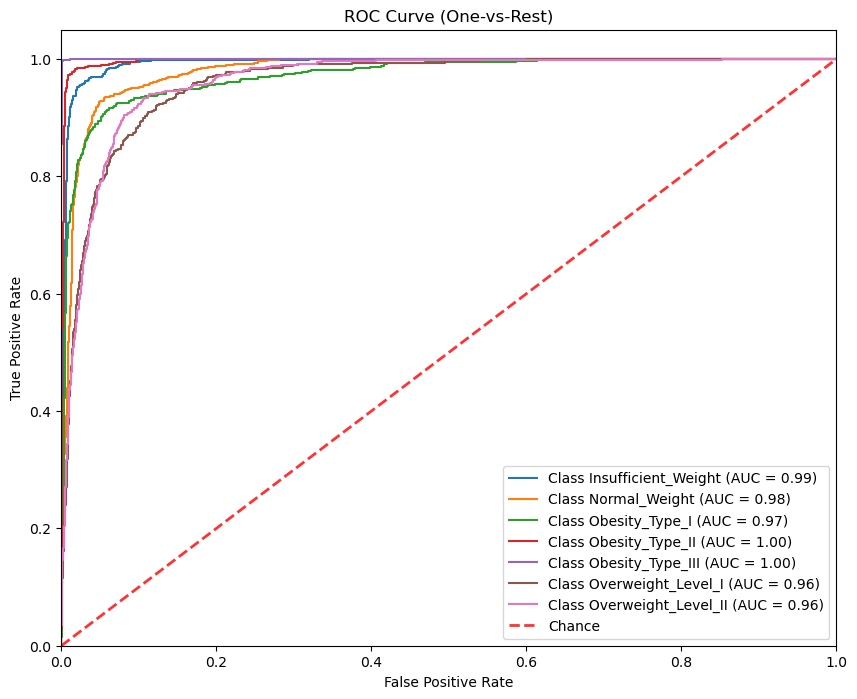

In [29]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 计算各种评估指标
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')
roc_auc = roc_auc_score(y_val, y_prob, multi_class='ovr')

# 输出评估指标
print(f"验证集准确率: {accuracy:.2f}")
print(f"验证集精确率: {precision:.2f}")
print(f"验证集召回率: {recall:.2f}")
print(f"验证集 F1 分数: {f1:.2f}")
print(f"验证集 ROC AUC: {roc_auc:.2f}")

# 计算并绘制混淆矩阵
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# 计算并绘制 ROC 曲线
n_classes = len(le.classes_)
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val == i, y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 绘制 ROC 曲线
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {le.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=0.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc="lower right")
plt.show()